# Affichage des images, création des sous dossiers et tests pour l'augmentation de données

Le dataset utilisé est le "Garbage Classification Dataset". 

Il s'agit d'un dataset Kaggle et il est disponible ici : https://www.kaggle.com/asdasdasasdas/garbage-classification (seulement 43 MB).

Imports des bibliothèques

In [ ]:
pip install split-folders

In [4]:
import os
import splitfolders

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from numpy import expand_dims

# 1 - Visualisation des images

In [5]:
# Affichage des classes du dataset
inputFolder = "Garbage classification"
labels = os.listdir(inputFolder)
nClasses = len(labels)
print(f"Le dataset comporte {nClasses} classes : {labels}")

Le dataset comporte 6 classes : ['paper', 'metal', 'cardboard', 'trash', 'plastic', 'glass']


In [6]:
# Affichage du nombre d'images dans chaque classe
total_images = 0
for label in labels:
    directory = os.path.join(inputFolder, label)
    nb = len(os.listdir(directory))
    total_images+=nb
    print("Nombre d'images de \"" + label + "\":\t", nb)

print("\nTotal d'images = ", total_images)

Nombre d'images de "paper":	 594
Nombre d'images de "metal":	 410
Nombre d'images de "cardboard":	 403
Nombre d'images de "trash":	 137
Nombre d'images de "plastic":	 482
Nombre d'images de "glass":	 501

Total d'images =  2527


Les classes sont relativement équilibrées : entre 400 et 600 images de chaque classe sauf la catégorie "trash" qui ne comporte que 137 images.

Le dataset est petit. On pourra utiliser une stratégie d'augmentation de données.

In [7]:
# Affichage de la taille des images
directory = os.path.join(inputFolder, 'cardboard')
path = os.path.join(directory, os.listdir(directory)[0])
img = image.load_img(path)
x = image.img_to_array(img)
print("Taille d'une image = ", x.shape)

Taille d'une image =  (384, 512, 3)


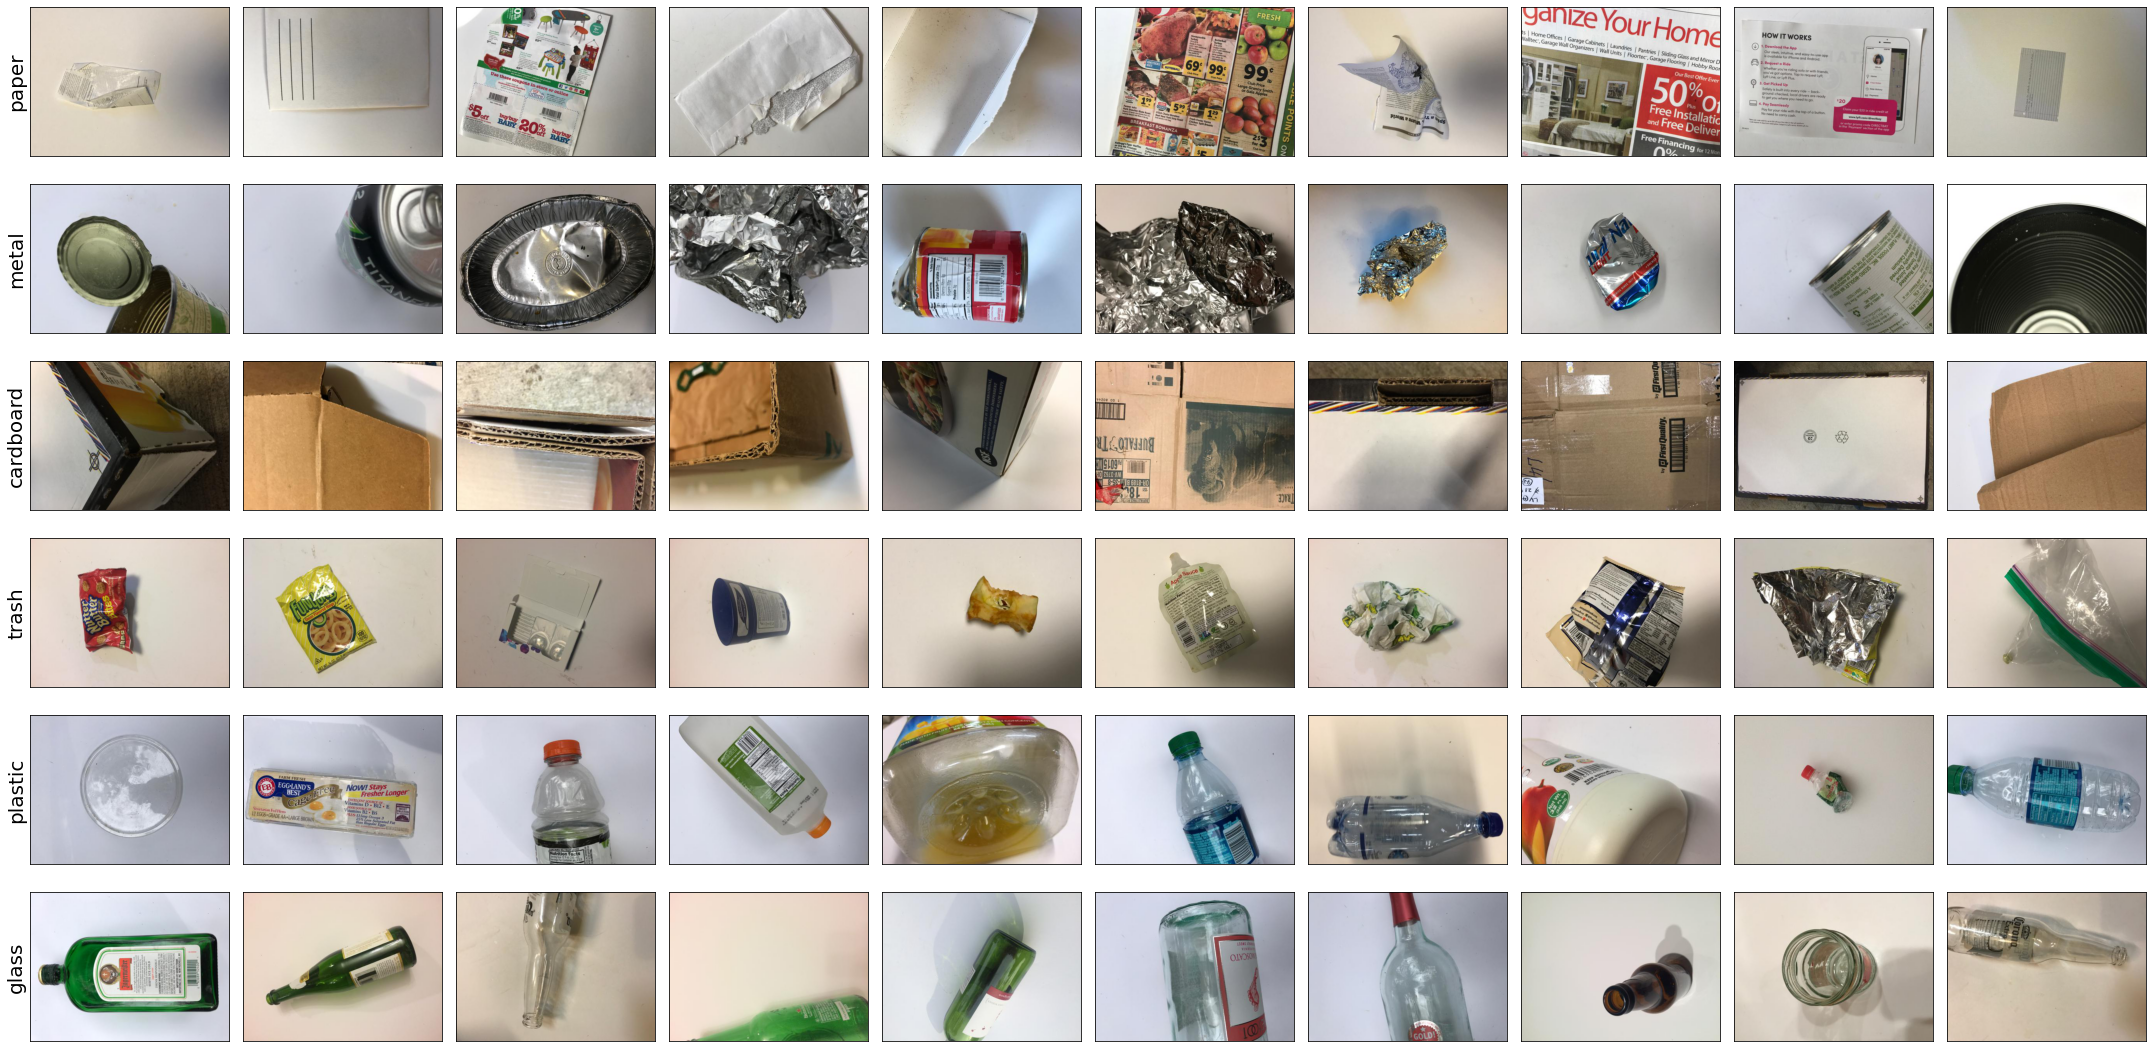

In [8]:
#Affichage de quelques images

plt.figure(figsize=(30,15))

for i in range(nClasses):

    directory = os.path.join(inputFolder, labels[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = image.load_img(path)
        
        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)
        
        #Ajout du label
        if j == 0:
            plt.ylabel(labels[i], fontsize=20)
        
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

# 2 - Création de 3 sous-dossiers : train, test et validation

Afin de pouvoir entraîner nos modèles, contrôler leurs performances pendant l'entraînement et les tester sur des images encore inconnues, nous générons 3 sous-datasets : un pour l'entraînement (train), un pour la validation (val) et un pour le test de performance final (test).

In [9]:
outputFolder = "Garbage_train_test_val"
proportion_val = 0.15
proportion_test = 0.15
proportion_train = 1 - proportion_val - proportion_test

splitfolders.ratio(inputFolder, output=outputFolder, seed=777, ratio=(proportion_train, proportion_val, proportion_test))

Copying files: 2527 files [00:39, 64.23 files/s]


# 3 - Augmentation de données

Le dataset est bien trop petit pour entraîner un modèle en évitant le surapprentissage, bien qu'il ne comporte que 6 classes. Afin de contourner cela, nous pouvons appliquer une stratégie d'augmentation de données. Le modèle s'entraînera alors sur un nombre plus conséquent d'images et sera plus performant. En revanche, les images des datasets de validation et de test ne seront pas augmentées artificiellement.

La bibliothèque Keras permet de faire de l'augmentation de données à l'aide de la classe ImageDataGenerator.

Plusieurs techniques peuvent être utilisées. En revanche, il ne faut utiliser que celle qui ont du sens pour nos images.

Admettons que le modèle de classification soit utilisé par un robot qu repère des déchets sur une plage ou dans l'eau, les déchets peuvent être dans n'importe quelle position (même à l'envers). De plus, le repérage pourra se faire à tout moment de la journée donc varier la luminosité aurait également du sens.

In [10]:
def displayAugmentedImages(datagen):
  plt.figure(figsize=(15,15))

  for i in range(2):

    #load image
    directory = os.path.join(inputFolder, labels[i])
    path = os.path.join(directory, os.listdir(directory)[0])
    img = image.load_img(path)
    x = image.img_to_array(img)
    samples = expand_dims(x, 0)
    # prepare iterator
    it = datagen.flow(samples, batch_size=1)

    for j in range(4):

      plt.subplot(4, 4, i*4 + j + 1)

      if j==0:
        plt.imshow(img)
        plt.xlabel("original", fontsize=20)
        plt.ylabel(labels[i], fontsize=20)

      else:
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image_ = batch[0].astype('uint8')
        # plot raw pixel data
        plt.imshow(image_)

  # show the figure
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
  plt.tight_layout()
  plt.show()

## Décalage
via les arguments *width_shift_range* et *height_shift_range* : il suffit de renseigner un nombre floatant qui représente le poucentage de la largeur et hauteur de l'image à décaler

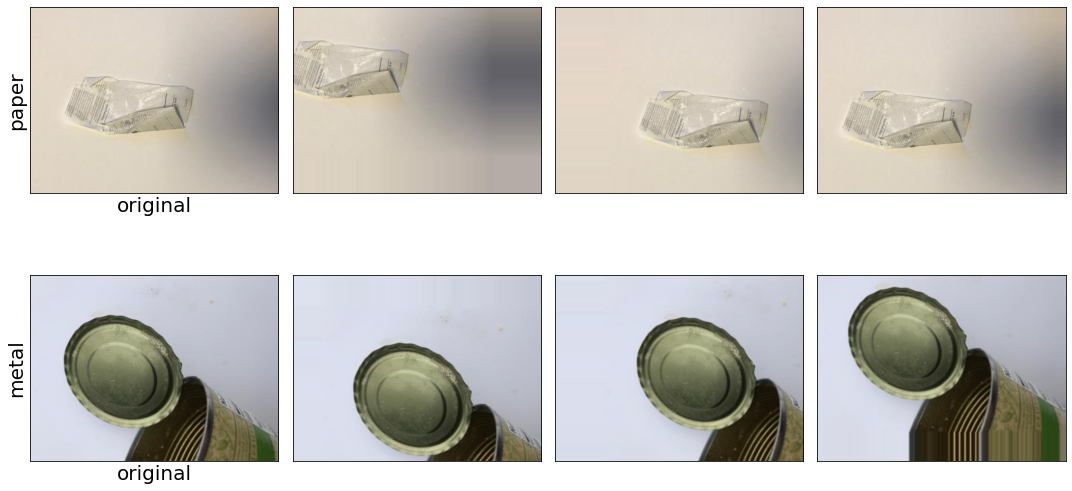

In [11]:
# create image data augmentation generator
datagen_shift = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)
displayAugmentedImages(datagen_shift)

## Retournement
via les arguments *horizontal_flip* et *vertical_flip* : il suffit de renseigner True pour ce type d'augmentation de données


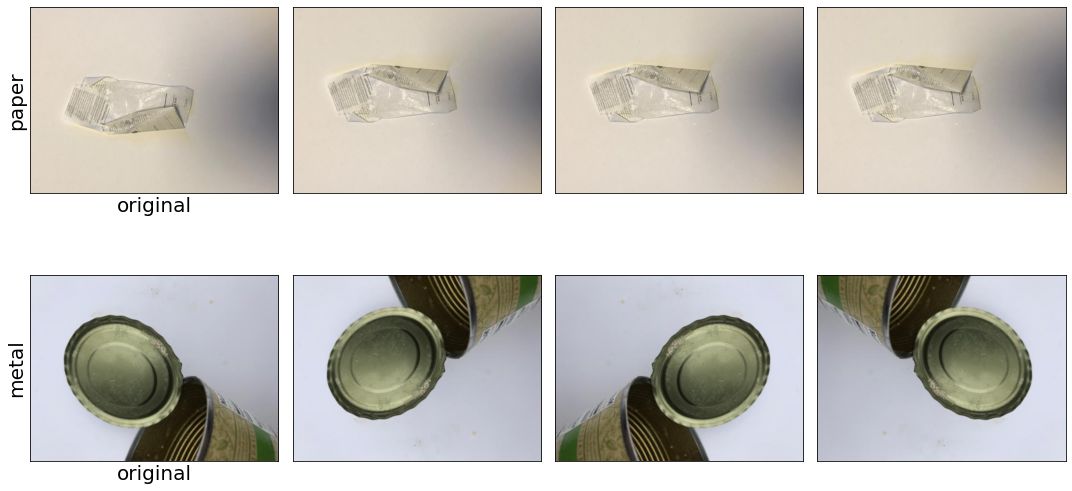

In [12]:
datagen_flip = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
displayAugmentedImages(datagen_flip)

## Rotation
via *rotation_range* : il faut indiquer l'angle de rotation maximal entre 0 et 360

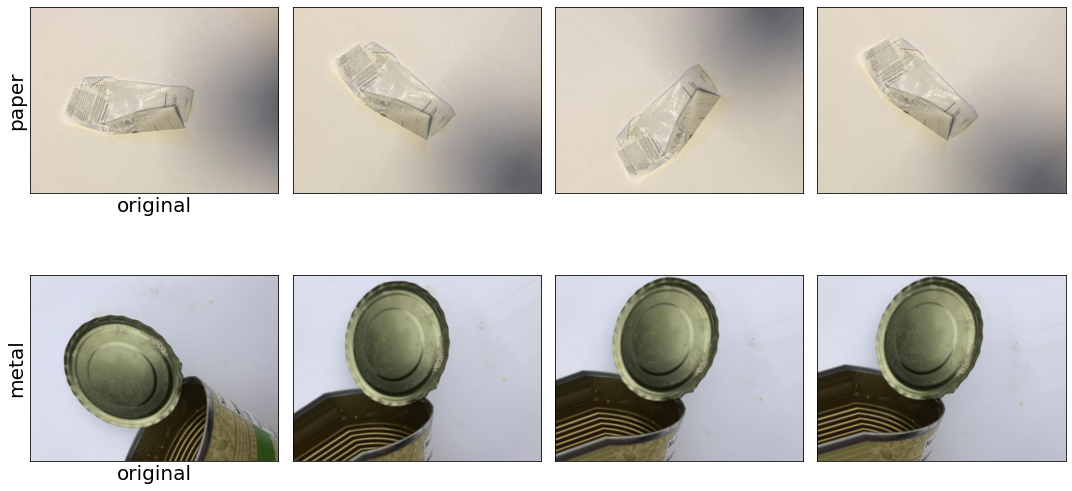

In [13]:
datagen_rotation = ImageDataGenerator(rotation_range = 90)
displayAugmentedImages(datagen_rotation)

## Luminosité
via *brightness_range* : il faut indiquer un intervalle [min, max] correspondant au pourcentage de luminosité qui peut varier. Les valeurs inférieures à 1 vont assombrir l'image tandis qu'au-dessus de 1 elles vont intensifier l'éclairage.

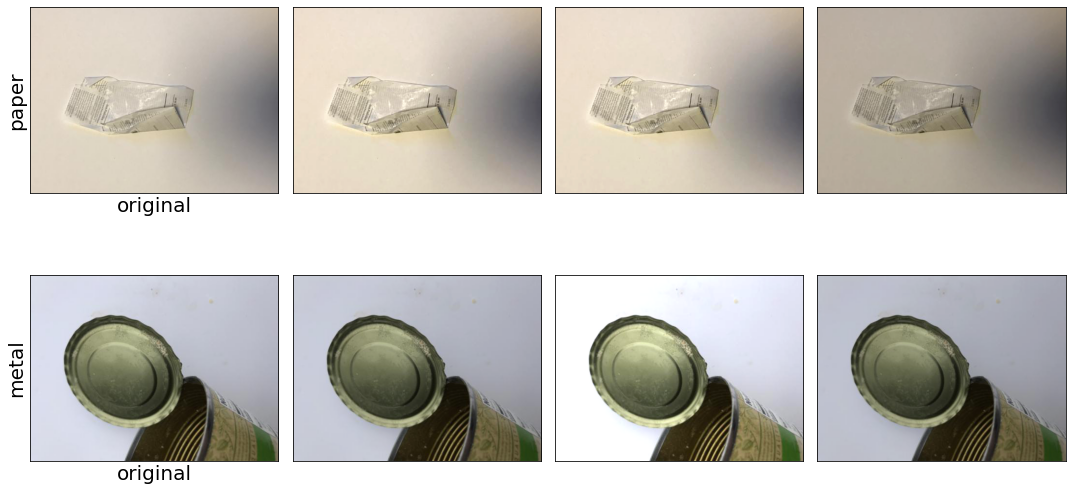

In [14]:
datagen_brightness = ImageDataGenerator(brightness_range = [0.8, 1.2])
displayAugmentedImages(datagen_brightness)

## Zoom
via *zoom_range*

Certaines images étant déjà coupées, il ne faut pas que le zoom soit trop grand.

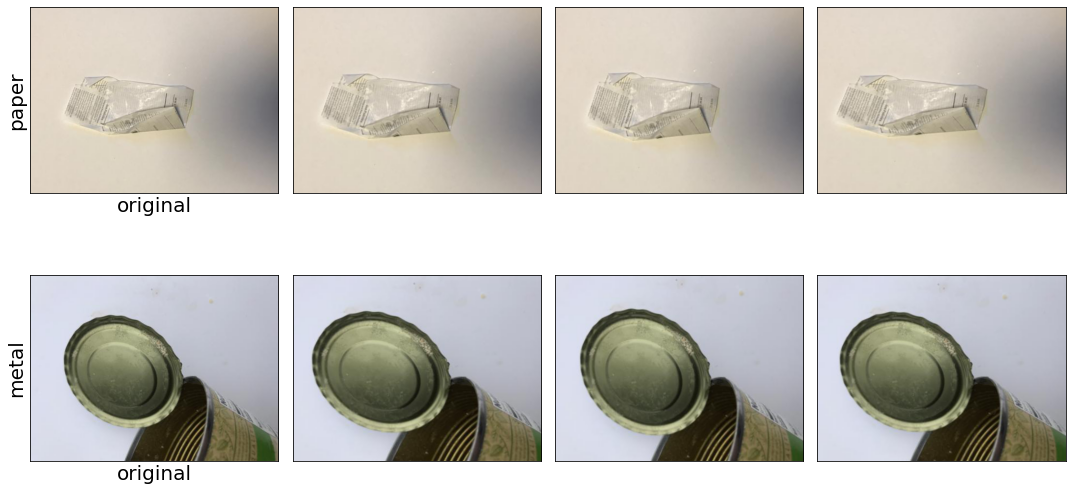

In [15]:
datagen_zoom = ImageDataGenerator(zoom_range = [0.8, 1])
displayAugmentedImages(datagen_zoom)

## Mix

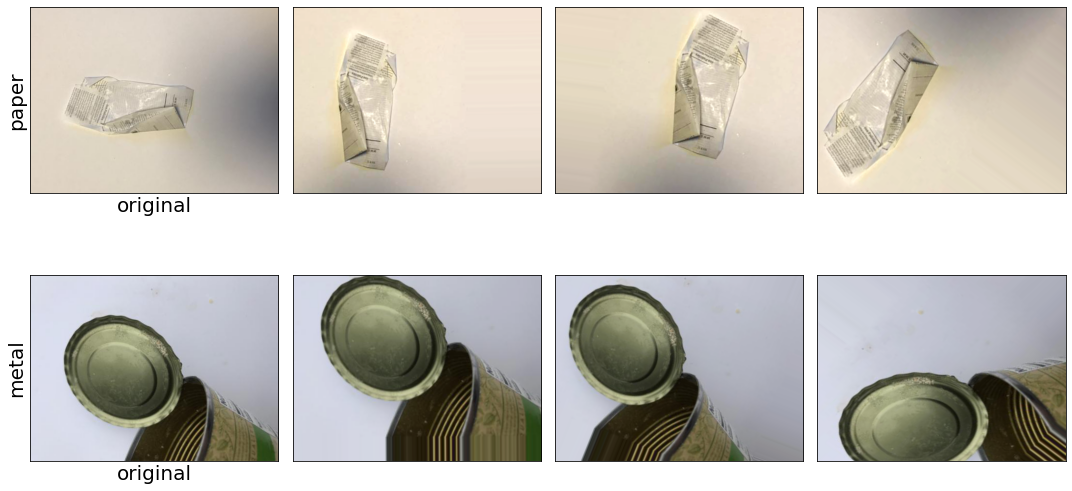

In [16]:
datagen_mix = ImageDataGenerator(width_shift_range=0.2, 
                                height_shift_range=0.2, 
                                horizontal_flip=True, 
                                vertical_flip=True,
                                rotation_range = 90,
                                brightness_range = [0.8, 1.2],
                                zoom_range = [0.8, 1])
displayAugmentedImages(datagen_mix)

Avec toutes les transformations en simultané, il apparaît des parties de l'image sans pixels. Pour combler ces endroits, nous pouvons utiliser l'argument *fill_mode*.

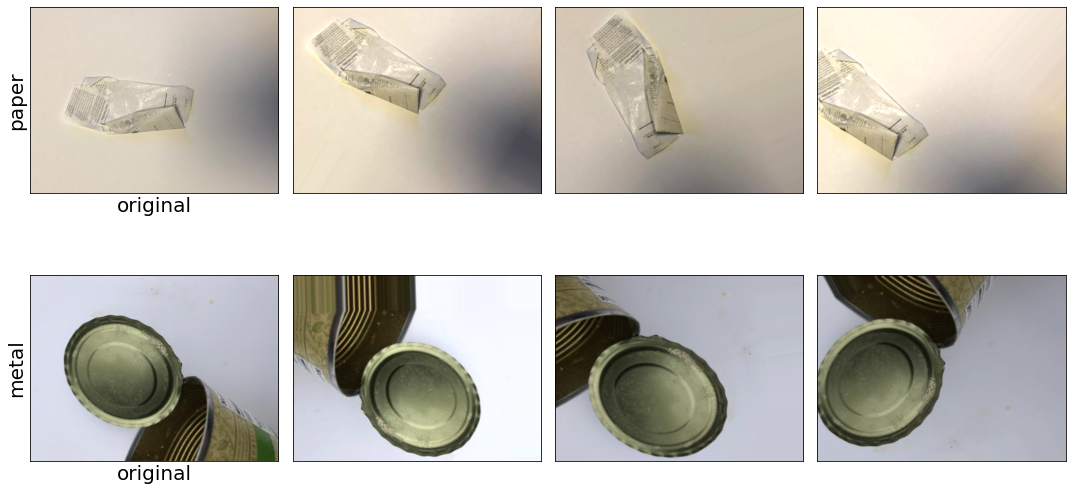

In [18]:
datagen_mix = ImageDataGenerator(width_shift_range=0.2, 
                                height_shift_range=0.2, 
                                horizontal_flip=True, 
                                vertical_flip=True,
                                rotation_range = 90,
                                brightness_range = [0.8, 1.2],
                                zoom_range = [0.8, 1], 
                                #to avoid deformations
                                fill_mode='nearest')
displayAugmentedImages(datagen_mix)